In [255]:
#importing necessary packages
import math
import numpy as np
import pandas as pd

#importing tensorflow and keras packages
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor

#importing matplotlib for visualisations
import matplotlib.pyplot as plt
import seaborn as sns

#importing sklearn packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score


#supressing warnings
import warnings
warnings.filterwarnings('ignore')

#loading in evaluation metrics from statsmodels
from statsmodels.tools.eval_measures import mse, rmse

#### Loading in the dataset in multiple parts as when pulled directly from HDFS it is split up into multiple blocks

In [482]:
part1_df = pd.read_csv('part-00000-5600618e-29bd-47b1-b674-47ff83c57f73-c000.csv')

In [483]:
part2_df = pd.read_csv('part-00001-5600618e-29bd-47b1-b674-47ff83c57f73-c000.csv')

In [484]:
df = pd.concat([part1_df, part2_df])

#### data understanding and preparation

In [259]:
df.head()

,datetime,rain,temp,wet_bulb,dew_point,vap_pressure,humidity,sea_pressure,wind_speed,wind_dir,sun,vis,cloud_height,clout_amount,date
0,2019-01-02T00:00:00.000Z,0.0,4.4,3.5,2.2,7.1,85,1042.4,2,290,0.0,18000,28,5,2019-01-02
1,2019-01-02T01:00:00.000Z,0.0,4.3,3.7,2.7,7.5,90,1043.1,3,70,0.0,18000,30,7,2019-01-02
2,2019-01-02T02:00:00.000Z,0.0,4.7,3.9,2.6,7.4,87,1043.2,2,340,0.0,18000,30,7,2019-01-02
3,2019-01-02T03:00:00.000Z,0.0,5.1,4.2,2.8,7.5,86,1043.3,2,320,0.0,18000,30,7,2019-01-02
4,2019-01-02T04:00:00.000Z,0.0,5.1,4.2,2.9,7.5,86,1043.2,3,100,0.0,18000,30,7,2019-01-02


In [260]:
#sorting values by datetime
df = df.sort_values('datetime')

In [261]:
df = df.reset_index().drop(columns='index')

In [263]:
df.head()

,datetime,rain,temp,wet_bulb,dew_point,vap_pressure,humidity,sea_pressure,wind_speed,wind_dir,sun,vis,cloud_height,clout_amount,date
0,2019-01-02T00:00:00.000Z,0.0,4.4,3.5,2.2,7.1,85,1042.4,2,290,0.0,18000,28,5,2019-01-02
1,2019-01-02T01:00:00.000Z,0.0,4.3,3.7,2.7,7.5,90,1043.1,3,70,0.0,18000,30,7,2019-01-02
2,2019-01-02T02:00:00.000Z,0.0,4.7,3.9,2.6,7.4,87,1043.2,2,340,0.0,18000,30,7,2019-01-02
3,2019-01-02T03:00:00.000Z,0.0,5.1,4.2,2.8,7.5,86,1043.3,2,320,0.0,18000,30,7,2019-01-02
4,2019-01-02T04:00:00.000Z,0.0,5.1,4.2,2.9,7.5,86,1043.2,3,100,0.0,18000,30,7,2019-01-02


In [351]:
df.describe()

,rain,temp,wet_bulb,dew_point,vap_pressure,humidity,sea_pressure,wind_speed,wind_dir,sun,vis,cloud_height,clout_amount
count,45241.000000,45241.000000,45241.000000,45241.000000,45241.000000,45241.000000,45241.000000,45241.000000,45241.000000,45241.000000,45241.000000,45241.000000,45241.000000
mean,0.091183,10.028536,8.537119,6.892100,10.375509,81.926770,1013.127022,9.099357,205.984616,0.168900,26647.728830,284.163436,5.563759
std,0.431982,5.029428,4.463000,4.549308,3.201364,11.827704,13.168481,4.386793,81.752517,0.322627,12535.303629,399.873695,2.196293
min,0.000000,-5.600000,-5.900000,-7.600000,3.400000,24.000000,961.800000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
25%,0.000000,6.500000,5.300000,3.500000,7.900000,75.000000,1004.800000,6.000000,140.000000,0.000000,20000.000000,24.000000,4.000000
50%,0.000000,10.000000,8.600000,7.000000,10.000000,84.000000,1014.600000,9.000000,230.000000,0.000000,25000.000000,50.000000,7.000000
75%,0.000000,13.700000,11.900000,10.200000,12.500000,91.000000,1022.400000,12.000000,270.000000,0.100000,30000.000000,250.000000,7.000000
max,13.800000,29.100000,21.400000,19.500000,22.600000,100.000000,1048.200000,35.000000,360.000000,1.000000,75000.000000,999.000000,9.000000


In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45241 entries, 0 to 45240
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datetime      45241 non-null  object 
 1   rain          45241 non-null  float64
 2   temp          45241 non-null  float64
 3   wet_bulb      45241 non-null  float64
 4   dew_point     45241 non-null  float64
 5   vap_pressure  45241 non-null  float64
 6   humidity      45241 non-null  int64  
 7   sea_pressure  45241 non-null  float64
 8   wind_speed    45241 non-null  int64  
 9   wind_dir      45241 non-null  int64  
 10  sun           45241 non-null  float64
 11  vis           45241 non-null  int64  
 12  cloud_height  45241 non-null  int64  
 13  clout_amount  45241 non-null  int64  
 14  date          45241 non-null  object 
dtypes: float64(7), int64(6), object(2)
memory usage: 5.2+ MB


In [266]:
df.isnull().sum()

datetime        0
rain            0
temp            0
wet_bulb        0
dew_point       0
vap_pressure    0
humidity        0
sea_pressure    0
wind_speed      0
wind_dir        0
sun             0
vis             0
cloud_height    0
clout_amount    0
date            0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

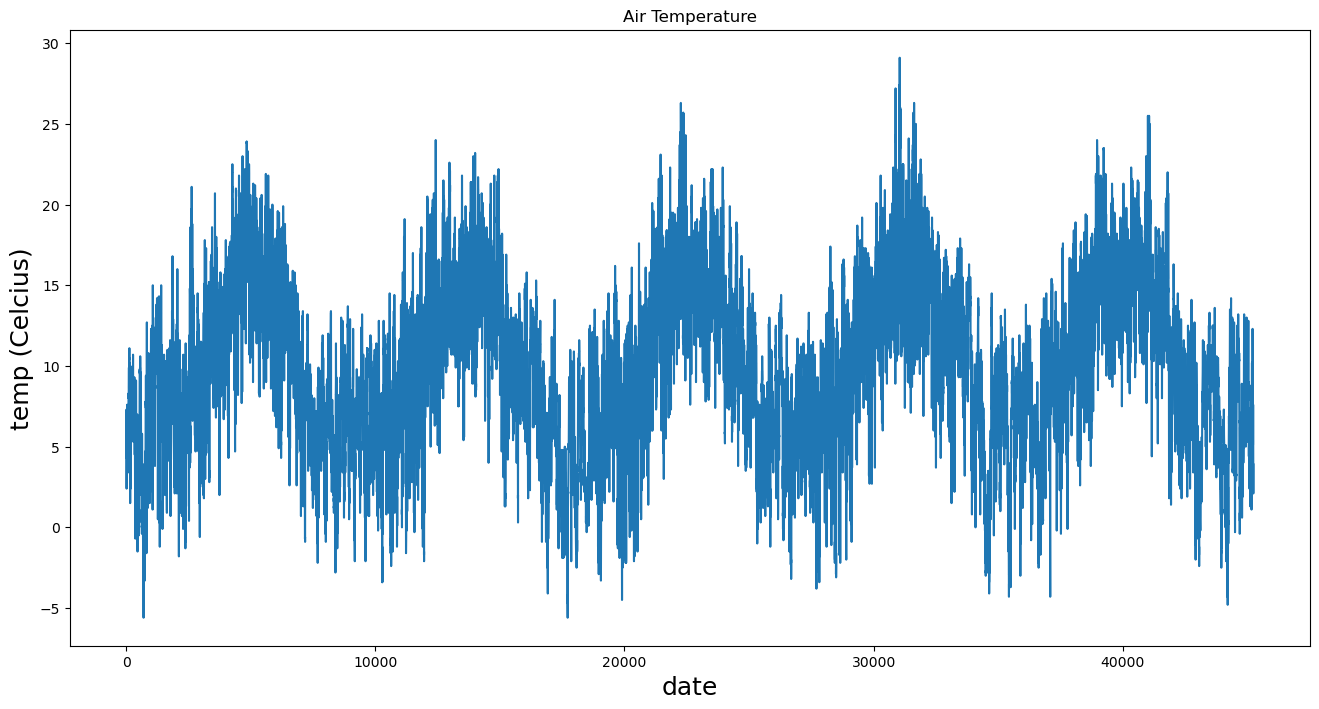

In [267]:
#taking a look at the temperature data
plt.figure(figsize=(16,8))
plt.title('Air Temperature')
plt.plot(df['temp'])
plt.xlabel('date', fontsize=18)
plt.ylabel('temp (Celcius)', fontsize=18)
plt.show

In [273]:
#majority of values are positive
print(len(df[df['temp']<0]))
print(len(df[df['temp']>=0]))

922
44319


# Modelling and Evaluation

models to be constructed and evaluated: 
- Univariate ANN (simple)
- Univariate ANN (more complex + tuned hyperparams)
- Multivariate ANN 
- Univariate LSTM 
- Univariate LSTM (more complex + tuned hyperparams)
- Multivariate LSTM

### creating functions to be used during modelling phase

*create_samples* will take the entire dataset (data), number of timesteps (n_steps) and training data size (train_size) as arguments.<br>
**n_steps** specifies how many previous observations should be considered by the network when making a prediction about the current observation.<br>
**train_size** specifies the precentage size of the dataset that should be used for training. Since the data in question is time series data, the train_test_split function cannot be utilised and the data will need to be split without being shuffled.

In [274]:
#defining function to creating training and testing samples for univariate models

def create_samples(data, n_steps, train_size):
    
    #getting the lenght of the training data
    training_len = math.ceil( len(data) * train_size )
    
    #splitting data into training/testing data data using slicing
    #since we are dealing with timeseries data we cannot use train_test_split
    training_data = data[0:training_len , :]
    testing_data = data[training_len - n_steps: , :]
    
    #defining empty arrays for appending independent and dependent features
    x_train =[]
    y_train =[]
    
    x_test = []
    y_test = data[training_len:]
    
    # iterating through the specified number of steps to create
    # multiple samples where each sample has a specified number of time steps and the output is a single time step.
    for i in range(n_steps, training_len):
        x_train.append(training_data[i - n_steps: i, 0])
        y_train.append(training_data[i, 0])
    
    for i in range(n_steps, len(testing_data)):
        x_test.append(testing_data[i - n_steps: i, 0])
        
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

*create_ANN* creates a sinple two laters feed forward neural network and the arguments are the relevant hyperparameters. This function will be used for fine tuning the hyperparameters.<br>


Similar to all Neural networks constructed during this project, the Multilayer perceptron created in *create_ANN* utilises Keras (a high-level API) which runs on top of TensorFlow (provides the computational backend for the constructed networks). <br>
The model is initialized as an object from Tensorflows sequential class. This is utilized to create models in a linear layer-by-layer stack.<br>
After initialising the model, each layer can be added in succession. Each layer is added as a *Dense* layer. This means that every neuron in the layer takes the input from all the other neurons of the previous layer.<br>
Within each Dense layer ,the number of neurons is defined using the arguments **layer_1** and **layer_2**. <br>
By providing **input_dim** in the first hidden layer, an input layer with *input_dim* number of neurons is implicitly created. *input_dim* should be equal to the number of input features.<br>
The **activation** argument can be used to specify the activation function used in each layer. This hyperparameter is used to calculate the output at each node (neuron) based on its individual inputs and weights. <br>
The **optimizer** argument is used within the compile method and determines what algorithm is to be used to change the attributes of the network to reduce the loss.<br>
Finally, the **loss** argument is used to determine what loss function (a function that compares the target and predicted outcome values), is to be minimised during the training process. 

output layer:<br>
For the output layer of regression tasks (like temperature forecasting), often no activation function is used, or a linear activation function is employed. This allows the network to predict continuous values without imposing any constraints on the output range

references: <br>
- https://www.tensorflow.org/guide/keras
- https://pypi.org/project/tensorflow/


In [275]:
def create_ANN(layer_1,  layer_2, input_dim, activation, optimizer='adam', loss='mse'):
    #initialising model as a Sequential model
    model = Sequential()
    #first hidden layer
    model.add(Dense(layer_1, input_dim=input_dim, activation=activation))
    #second hidden layer
    model.add(Dense(layer_2, activation=activation))
    #output layer with only 1 neuron, no activation here due to regression task 
    model.add(Dense(1))
    #compiling the model
    model.compile(loss=loss, optimizer=optimizer)
    return model

*create_mv_samples* is an extension on *create_samples* but for the multivariate models. In this case, an additional argument **target** is required which indicates the target variable values from the dataset. <br>

For the multivariate models, a variety of historical weather readings as well as historical temperature readings at **n_steps** number of timesteps from the past are used to predict the current observation. 

In [276]:
def create_mv_samples(data, target, train_size, n_steps):
    #getting the lenght of the training data
    training_len = math.ceil( len(data) * train_size )
    
    #splitting data into training/testing data data using slicing
    #since we are dealing with timeseries data we cannot use train_test_split
    training_data = data[0:training_len , :]
    testing_data = data[training_len - n_steps: , :]
    
    #defining empty arrays for appending independent and dependent features
    x_train = []
    y_train = []
    
    x_test = []
    y_test = target[training_len:]
    
    # iterating through the specified number of steps to create
    # multiple samples where each sample has a specified number of time steps and the output is a single time step.
    for i in range(n_steps, training_len):
        x_train.append(training_data[i - n_steps: i])
        y_train.append(target[i])
    
    for i in range(n_steps, len(testing_data)):
        x_test.append(testing_data[i - n_steps: i])
        
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
    

### Setting up univariate ANN for temperature predictions

In [412]:
#selecting only temperature from the dataframe
data = df.filter(['temp'])

In [278]:
#selecting out the values of temp to create an array of values, 
#Tensorflow only accepts NumPy arrays as parameters
data = data.values

In [279]:
data

array([[4.4],
       [4.3],
       [4.7],
       ...,
       [3.2],
       [3.5],
       [3.9]])

For this model the number of timesteps is chosen to be 48. Since the dataset is broken down into hourly data, 48 timesteps would mean that each predicted observation uses the previous 2 days worth of hourly temperature data which should be sufficient for an accurate model.<br>
80% of the dataset is used for training, by setting the train_size to .80. This should give a sufficient amount of data to train the model while leaving a large enough testing data size to validate the model.

In [280]:
#creating samples with a timestep of 40 and a training size of 80%
x_train, y_train, x_test, y_test  = create_samples(data, 48, .80)

In [281]:
len(x_test)

9048

In [282]:
#scaling the data 
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test =  scaler.fit_transform(x_test)

### Model 1 - univariate ANN
setting up a basic Feed Forward neural network with an input layer, two hidden layers and an output layer

For the initial model the following hyperparameters were used: 
- To keep the model relatively simple, the number of nuerons in both hidden layers is set to 20. 
- input_dim is set to 48, representing the 48 timestep temperature features being inputted into the network.
-The **adam** optimizer is chosen due to it being one of the most widely used optimizers because of its robustness across various model architectures and its faster convergence compared with other optimizers.
- **relu** activation function was decided to be used for the hidden layers since it introduces non-linearity into the model (corresponding to the nature of the temperature data). It should be noted that within create_ANN, the output layer activation is left as the default **linear** activation to ensure the output is a numerical value that is not squashed or transformed. Using relu with the linear activation function allows negative outputs to be predicted.
- **mse** (mean squared error) is chosen as the loss function as this is the standard loss function utilized in most regression tasks. It directs the model to minimise the squared differences between the predicted and target values.

In [285]:
model_1 = create_ANN(layer_1=20, layer_2=20,input_dim=48, activation='relu',optimizer='adam', loss='mse')

The final two hyperparameters that need to be tuned are the **epochs** (the number of iterations the network will be trained on) and the **batch_size** (the number of training samples that are fed into the network at once).

- 50 epochs was chosen for this initial model to create a baseline. This number was chosen as it is a sufficient number of epochs to generate accurate results wihtout making the model two complex.
- 100 was chosen for the batch size due to the size of the data and the speed at which the model performed with this batch size.

In [80]:
#fitting the model on to the training and testing data
model_history_1 = model_1.fit(x_train, y_train, epochs=50, batch_size=100,  verbose=2) 

Epoch 1/50
362/362 - 1s - loss: 27.1453 - 644ms/epoch - 2ms/step
Epoch 2/50
362/362 - 0s - loss: 3.4353 - 297ms/epoch - 820us/step
Epoch 3/50
362/362 - 0s - loss: 1.1563 - 299ms/epoch - 825us/step
Epoch 4/50
362/362 - 0s - loss: 0.8262 - 297ms/epoch - 821us/step
Epoch 5/50
362/362 - 0s - loss: 0.7450 - 309ms/epoch - 855us/step
Epoch 6/50
362/362 - 0s - loss: 0.7029 - 288ms/epoch - 797us/step
Epoch 7/50
362/362 - 0s - loss: 0.6889 - 288ms/epoch - 796us/step
Epoch 8/50
362/362 - 0s - loss: 0.6685 - 290ms/epoch - 801us/step
Epoch 9/50
362/362 - 0s - loss: 0.6661 - 290ms/epoch - 801us/step
Epoch 10/50
362/362 - 0s - loss: 0.6526 - 286ms/epoch - 791us/step
Epoch 11/50
362/362 - 0s - loss: 0.6539 - 376ms/epoch - 1ms/step
Epoch 12/50
362/362 - 0s - loss: 0.6489 - 305ms/epoch - 842us/step
Epoch 13/50
362/362 - 0s - loss: 0.6532 - 291ms/epoch - 804us/step
Epoch 14/50
362/362 - 0s - loss: 0.6438 - 286ms/epoch - 791us/step
Epoch 15/50
362/362 - 0s - loss: 0.6461 - 300ms/epoch - 830us/step
Epoch 1

In [81]:
model_history_1.history.keys()

dict_keys(['loss'])

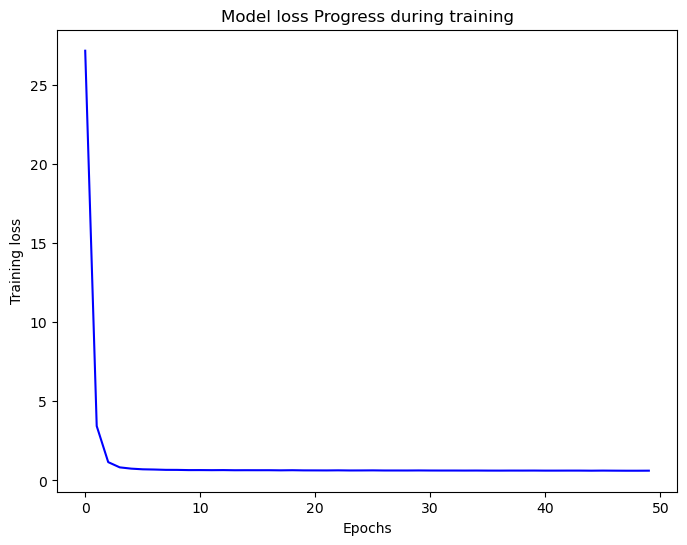

In [82]:
#plotting the loss as a function of number of epochs to visualise how the model is learning
plt.figure(figsize=(8,6))
plt.plot(model_history_1.history['loss'], color='blue')
plt.title('Model loss Progress during training')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()

In [83]:
#making predictions from the trained neural network on the train and test data
y_preds_train_m_1 = model_1.predict(x_train)
y_preds_test_m_1 = model_1.predict(x_test) 

283/283 [==============================] - 0s 695us/step


**evaluation metrics for regression problem**:
- *R-Squared* (r2) is the proportion of variance explained by the model(i.e goodness of fit). It ranges from 0 to 1, with 0 relating to a model that predicts 0% of the relationship between the variables and 1 relating to model that correctly predicts 100% of the output.

- *Mean Squared Error* (mse) is one of the most common metrics for regression algorithms. It assesses the average squared difference between the observed and predicted values.

In [84]:
## accuracy metrics for regression model: 
r_squared_test_m_1 = r2_score(y_test,y_preds_test_m_1)
r_squared_train_m_1 = r2_score(y_train,y_preds_train_m_1)

mse_test_m_1 = mse(y_test, y_preds_test_m_1)

print(f'1) the mean squared error for the test set is: {mse_test_m_1[0]}')
print(f'2) the r^2 score for the test set is: {r_squared_test_m_1}')
print(f'3) the r^2 score for the training set is: {r_squared_train_m_1}')

1) the mean squared error for the test set is: 1.0155041522887516
2) the r^2 score for the test set is: 0.9588463935450104
3) the r^2 score for the training set is: 0.9761725160932618


### tuning hyperparameters using randomizedSearchCV

There are multiple ways at tuning neural network hyperparameters using optimization algorithms such as GridSearchCV, RandomizedSearchCV and Bayesian optimization. For this project **RandomizedSearchCV** was utilized to try to obtain optimal hyperparamters for the Multilayer perceptron network. This was chosen for the following reasons:
- Due to the larger number of hyperparameters that are required to be tuned for neural networks, RandomizedSearchCV provides a more efficient alternative to GridSearchCV.
- Due to its ease of implementation compared to Bayesian optimization.

In [290]:
#defining dictionary of hyperparams to be tuned
param_grid = {
    'layer_1':[10, 15, 20, 25, 30],
    'layer_2':[10, 15, 20, 25, 30],
    'epochs':[30,40,50,60,70],
    'batch_size':[50, 80, 100],
    'activation':['relu','leaky_relu']}

The below wrapper class (KerasRegressor) provided by scikeras enables keras models to be used as if it were a scikit-learn classifier, enabling randomizedSearchCV 

reference: https://pypi.org/project/scikeras/0.1.8/

In [291]:
#creating wrapper around the keras model feeding the parameter space
keras_reg = KerasRegressor(model=create_ANN,layer_1=param_grid['layer_1'],
                           layer_2=param_grid['layer_2'],input_dim=48,
                           activation=param_grid['activation'],verbose=0)

Regular k-fold cross validation cannot be used with time series data due to the fact that the data is required to be kept in the same order and not split randomly. Therefore **TimeSeriesSplit** is utilised to maintain the temporal order of the data while splitting the data into multiple consecutive fold. 

In [292]:
my_cv = TimeSeriesSplit(n_splits=5).split(x_train)

In [293]:
#initialising the randomizedSearchCV
randSearch = RandomizedSearchCV(keras_reg, param_grid,cv=my_cv, scoring='r2', verbose=2, n_jobs=1)

#fitting the model to the training data
randSearch.fit(x_train, y_train)
print(randSearch.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END activation=tanh, batch_size=50, epochs=50, layer_1=15, layer_2=20; total time=   7.4s
[CV] END activation=tanh, batch_size=50, epochs=50, layer_1=15, layer_2=20; total time=  13.1s
[CV] END activation=tanh, batch_size=50, epochs=50, layer_1=15, layer_2=20; total time=  15.2s
[CV] END activation=tanh, batch_size=50, epochs=50, layer_1=15, layer_2=20; total time=  19.7s
[CV] END activation=tanh, batch_size=50, epochs=50, layer_1=15, layer_2=20; total time=  24.1s
[CV] END activation=relu, batch_size=50, epochs=70, layer_1=30, layer_2=20; total time=   7.2s
[CV] END activation=relu, batch_size=50, epochs=70, layer_1=30, layer_2=20; total time=  13.9s
[CV] END activation=relu, batch_size=50, epochs=70, layer_1=30, layer_2=20; total time=  20.3s
[CV] END activation=relu, batch_size=50, epochs=70, layer_1=30, layer_2=20; total time=  26.9s
[CV] END activation=relu, batch_size=50, epochs=70, layer_1=30, layer_2=20; total ti

In [294]:
print(randSearch.best_params_)

{'layer_2': 10, 'layer_1': 30, 'epochs': 50, 'batch_size': 50, 'activation': 'leaky_relu'}


### Model 2 - univariate ANN with tuned hyperparameters

In [295]:
#adding in hyperparameters from best_params_ output above
model_2 = create_ANN(layer_1=10, layer_2=30, input_dim=48,optimizer='adam', activation='leaky_relu')

In [296]:
#fitting the model
model_history_2 = model_2.fit(x_train, y_train, epochs=50, batch_size=50,  verbose=2) 

Epoch 1/50
723/723 - 1s - loss: 21.8053 - 891ms/epoch - 1ms/step
Epoch 2/50
723/723 - 1s - loss: 1.2826 - 561ms/epoch - 776us/step
Epoch 3/50
723/723 - 1s - loss: 0.8407 - 581ms/epoch - 804us/step
Epoch 4/50
723/723 - 1s - loss: 0.7333 - 574ms/epoch - 794us/step
Epoch 5/50
723/723 - 1s - loss: 0.6993 - 565ms/epoch - 781us/step
Epoch 6/50
723/723 - 1s - loss: 0.6753 - 613ms/epoch - 848us/step
Epoch 7/50
723/723 - 1s - loss: 0.6711 - 565ms/epoch - 781us/step
Epoch 8/50
723/723 - 1s - loss: 0.6572 - 588ms/epoch - 814us/step
Epoch 9/50
723/723 - 1s - loss: 0.6528 - 618ms/epoch - 855us/step
Epoch 10/50
723/723 - 1s - loss: 0.6493 - 607ms/epoch - 839us/step
Epoch 11/50
723/723 - 1s - loss: 0.6523 - 592ms/epoch - 819us/step
Epoch 12/50
723/723 - 1s - loss: 0.6455 - 601ms/epoch - 832us/step
Epoch 13/50
723/723 - 1s - loss: 0.6452 - 638ms/epoch - 883us/step
Epoch 14/50
723/723 - 1s - loss: 0.6450 - 685ms/epoch - 948us/step
Epoch 15/50
723/723 - 1s - loss: 0.6387 - 600ms/epoch - 830us/step
Epoch

In [297]:
model_history_2.history.keys()

dict_keys(['loss'])

In [298]:
#making predicitons with new model
y_preds_train_m_2 = model_2.predict(x_train)
y_preds_test_m_2 = model_2.predict(x_test) 

283/283 [==============================] - 0s 699us/step


In [299]:
## accuracy metrics for regression model: 
r_squared_test_m_2 = r2_score(y_test,y_preds_test_m_2)
r_squared_train_m_2 = r2_score(y_train,y_preds_train_m_2)

mse_test_m_2 = mse(y_test, y_preds_test_m_2)

print(f'1) the mean squared error for the test set is: {mse_test_m_2[0]}')
print(f'2) the r^2 score for the test set is: {r_squared_test_m_2}')
print(f'3) the r^2 score for the training set is: {r_squared_train_m_2}')

1) the mean squared error for the test set is: 0.9026416230719727
2) the r^2 score for the test set is: 0.9634201809593049
3) the r^2 score for the training set is: 0.9762225430485922


##  multivariate ANN - using other weather readings to determine temperature

For the mulitvariate model set up, different weather readings are also taking into consideration by the model when making predictions on the temperature. 

In [300]:
df

,datetime,rain,temp,wet_bulb,dew_point,vap_pressure,humidity,sea_pressure,wind_speed,wind_dir,sun,vis,cloud_height,clout_amount,date
0,2019-01-02T00:00:00.000Z,0.0,4.4,3.5,2.2,7.1,85,1042.4,2,290,0.0,18000,28,5,2019-01-02
1,2019-01-02T01:00:00.000Z,0.0,4.3,3.7,2.7,7.5,90,1043.1,3,70,0.0,18000,30,7,2019-01-02
2,2019-01-02T02:00:00.000Z,0.0,4.7,3.9,2.6,7.4,87,1043.2,2,340,0.0,18000,30,7,2019-01-02
3,2019-01-02T03:00:00.000Z,0.0,5.1,4.2,2.8,7.5,86,1043.3,2,320,0.0,18000,30,7,2019-01-02
4,2019-01-02T04:00:00.000Z,0.0,5.1,4.2,2.9,7.5,86,1043.2,3,100,0.0,18000,30,7,2019-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45236,2024-02-29T20:00:00.000Z,0.0,2.5,1.4,-0.4,5.9,80,997.2,7,200,0.0,25000,999,1,2024-02-29
45237,2024-02-29T21:00:00.000Z,0.0,2.1,1.0,-0.9,5.7,80,996.1,7,190,0.0,25000,999,1,2024-02-29
45238,2024-02-29T22:00:00.000Z,0.0,3.2,1.5,-1.6,5.4,71,994.6,7,170,0.0,25000,170,6,2024-02-29
45239,2024-02-29T23:00:00.000Z,0.0,3.5,1.9,-0.8,5.7,73,993.3,7,150,0.0,30000,120,7,2024-02-29


In [301]:
#filtering out the features to be passed to model
df_new = df.drop(columns=['date'])

In [302]:
df_new.head()

,datetime,rain,temp,wet_bulb,dew_point,vap_pressure,humidity,sea_pressure,wind_speed,wind_dir,sun,vis,cloud_height,clout_amount
0,2019-01-02T00:00:00.000Z,0.0,4.4,3.5,2.2,7.1,85,1042.4,2,290,0.0,18000,28,5
1,2019-01-02T01:00:00.000Z,0.0,4.3,3.7,2.7,7.5,90,1043.1,3,70,0.0,18000,30,7
2,2019-01-02T02:00:00.000Z,0.0,4.7,3.9,2.6,7.4,87,1043.2,2,340,0.0,18000,30,7
3,2019-01-02T03:00:00.000Z,0.0,5.1,4.2,2.8,7.5,86,1043.3,2,320,0.0,18000,30,7
4,2019-01-02T04:00:00.000Z,0.0,5.1,4.2,2.9,7.5,86,1043.2,3,100,0.0,18000,30,7


In [303]:
#datetime will not be used as an input feature to the model since the data is timeseries (at regular
# intervals). Therefore it will be set as the index:
df_new.index = df_new['datetime']

In [304]:
df_new = df_new.drop(columns='datetime')

In [305]:
df_new.head()

,rain,temp,wet_bulb,dew_point,vap_pressure,humidity,sea_pressure,wind_speed,wind_dir,sun,vis,cloud_height,clout_amount
datetime,,,,,,,,,,,,,
2019-01-02T00:00:00.000Z,0.0,4.4,3.5,2.2,7.1,85,1042.4,2,290,0.0,18000,28,5
2019-01-02T01:00:00.000Z,0.0,4.3,3.7,2.7,7.5,90,1043.1,3,70,0.0,18000,30,7
2019-01-02T02:00:00.000Z,0.0,4.7,3.9,2.6,7.4,87,1043.2,2,340,0.0,18000,30,7
2019-01-02T03:00:00.000Z,0.0,5.1,4.2,2.8,7.5,86,1043.3,2,320,0.0,18000,30,7
2019-01-02T04:00:00.000Z,0.0,5.1,4.2,2.9,7.5,86,1043.2,3,100,0.0,18000,30,7


In [306]:
#extracing the features as arrays instead of a dataframe, since tensorflow only accepts NumPy arrays as parameters
df_new = df_new.values

In [307]:
#creating the target variable by extracting out the "temp" row at index 0
target = df_new[:,1]

In [308]:
target

array([4.4, 4.3, 4.7, ..., 3.2, 3.5, 3.9])

In [309]:
#scaling the data
scaler = StandardScaler()
df_new = scaler.fit_transform(df_new)

For this model the number of timesteps is chosen to be 48, similar to the univariate model. <br>
80% of the dataset is used again for training.<br>
The new independent features are input into the function as *df_new* and the target variable as *target*.

In [310]:
x_train, y_train, x_test, y_test = create_mv_samples(df_new,target, 0.80, 48)

In [311]:
#taking a look at the shapes of the datasets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((36145, 48, 13), (9048, 48, 13), (36145,), (9048,))

In [312]:
#flattening the x_train and x_test arrays from 3D to 2D arrays so that they can be passed to model
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [313]:
x_train.shape, x_test.shape

((36145, 624), (9048, 624))

In [342]:
#creating the model with same hyperparameters as chosen from optimized univariate model
model_3 = create_ANN(layer_1=10, layer_2=30, input_dim= x_train.shape[1], optimizer='adam', activation='leaky_relu')

In [343]:
model_history_3 = model_3.fit(x_train, y_train, epochs=50, batch_size=50,  verbose=2) 

Epoch 1/50
723/723 - 1s - loss: 7.7249 - 1s/epoch - 2ms/step
Epoch 2/50
723/723 - 1s - loss: 1.3136 - 760ms/epoch - 1ms/step
Epoch 3/50
723/723 - 1s - loss: 0.9897 - 764ms/epoch - 1ms/step
Epoch 4/50
723/723 - 1s - loss: 0.8547 - 733ms/epoch - 1ms/step
Epoch 5/50
723/723 - 1s - loss: 0.7837 - 675ms/epoch - 933us/step
Epoch 6/50
723/723 - 1s - loss: 0.7291 - 666ms/epoch - 922us/step
Epoch 7/50
723/723 - 1s - loss: 0.6939 - 678ms/epoch - 938us/step
Epoch 8/50
723/723 - 1s - loss: 0.6600 - 675ms/epoch - 933us/step
Epoch 9/50
723/723 - 1s - loss: 0.6363 - 663ms/epoch - 916us/step
Epoch 10/50
723/723 - 1s - loss: 0.6232 - 675ms/epoch - 933us/step
Epoch 11/50
723/723 - 1s - loss: 0.6049 - 691ms/epoch - 956us/step
Epoch 12/50
723/723 - 1s - loss: 0.5895 - 660ms/epoch - 914us/step
Epoch 13/50
723/723 - 1s - loss: 0.5771 - 663ms/epoch - 916us/step
Epoch 14/50
723/723 - 1s - loss: 0.5724 - 659ms/epoch - 911us/step
Epoch 15/50
723/723 - 1s - loss: 0.5523 - 704ms/epoch - 974us/step
Epoch 16/50
723

In [344]:
#making predictions from the training neural network
y_preds_train_m_3 = model_3.predict(x_train)
y_preds_test_m_3 = model_3.predict(x_test) 

283/283 [==============================] - 0s 741us/step


In [345]:
y_preds_test_m_3 = y_preds_test_m_3.reshape(1,-1)[0]

In [346]:
## accuracy metrics for regression model: 
r_squared_test_m_3 = r2_score(y_test,y_preds_test_m_3)
r_squared_train_m_3 = r2_score(y_train,y_preds_train_m_3)

mse_test_m_3 = mse(y_test, y_preds_test_m_3)

print(f'1) the mean squared error for the test set is: {mse_test_m_3}')
print(f'2) the r^2 score for the test set is: {r_squared_test_m_3}')
print(f'3) the r^2 score for the training set is: {r_squared_train_m_3}')

1) the mean squared error for the test set is: 0.6853295080352589
2) the r^2 score for the test set is: 0.9722268187657247
3) the r^2 score for the training set is: 0.9847183815543946


## LSTM for temperature predictions - univariate model

The second type of neural network to be implemented as part of this project is a type of Recurrent Neural Network (RNN) called a Long Short-Term Memory (LSTM) network. This model was chosen as unlike traditional neural networks LSTM incorporates feedback connections making it highly effective in understanding and predicting patterns in sequential data (time series).<br>

In [453]:
#selecting only temperature from the dataframe
data = df.filter(['temp'])

In [454]:
#selecting out the values of temp to create an array of values
data = data.values

In [455]:
#just using historical temperature data as input to model
data

array([[4.4],
       [4.3],
       [4.7],
       ...,
       [3.2],
       [3.5],
       [3.9]])

In [456]:
#creating samples with a timestep of 48 and a training size of 80%
x_train, y_train, x_test, y_test  = create_samples(data, 48, .80)

In [457]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((36145, 48), (36145,), (9048, 48), (9048, 1))

In [458]:
#scaling the data 
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test =  scaler.fit_transform(x_test)

Since RNNs, and specifically LSTMs, used in tensorflow require the input data to be in the form of a 3D array, the data needs to be reshaped again:

In [460]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape)
print(x_test.shape)

(36145, 48, 1)
(9048, 48, 1)


- Similar to the MLP set up, the model is initialized as an object from TensorFlows sequential class.<br>
- The two LSTM layers are set up with 20 neurons each. This configuration was chosen as it creates a baseline model which isnt too complex. The first hidden layer specifies the shape of the input in the hyperparameter **input_shape**. x_train.shape[1] indicates the number of time steps and 1 indicates there is one feature at each time step.<br>
- **return_sequences** must always be specified if the current hidden layer is connected to another LSTM layer. specifying return_sequences = False (or leaving blank) indicates the last LSTM layer in the network.<br>
- No activation function is specified in any of the LSTM layers.This is because the default activation function is the hyperbolic tangent (*tanh*) which introduces non-linearity into the model and is commonly left as the activation function in LSTM architectures. *ReLu* has traditionally been regarded as inappropriate for use with LSTMs, so this wont be used here.<br>
- A *Dense* layer with one neuron (representing one output value) serves as an output layer of the model. The default *linear* activation function is used for this layer due to the nature of the data being predicted.


In [124]:
model_lstm_1 = Sequential()
model_lstm_1.add(LSTM(20, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model_lstm_1.add(LSTM(20, return_sequences = False ))
model_lstm_1.add(Dense(1))

mean squared error (mse) is used for the loss function as it is appropriate for regression problems, while *adam* is used again as the optimizer:

In [125]:
model_lstm_1.compile(loss='mse', optimizer='adam')

In [126]:
#fitting the lstm model with 50 epochs and a batch size of 100
lstm_history = model_lstm_1.fit(x_train, y_train, epochs = 50, batch_size = 100)

Epoch 1/50
362/362 [==============================] - 10s 19ms/step - loss: 35.9353
Epoch 2/50
362/362 [==============================] - 7s 20ms/step - loss: 5.8212
Epoch 3/50
362/362 [==============================] - 7s 20ms/step - loss: 2.3362
Epoch 4/50
362/362 [==============================] - 7s 20ms/step - loss: 1.4133
Epoch 5/50
362/362 [==============================] - 8s 21ms/step - loss: 1.0751
Epoch 6/50
362/362 [==============================] - 7s 20ms/step - loss: 0.9151
Epoch 7/50
362/362 [==============================] - 8s 21ms/step - loss: 0.8293
Epoch 8/50
362/362 [==============================] - 7s 20ms/step - loss: 0.7747
Epoch 9/50
362/362 [==============================] - 7s 21ms/step - loss: 0.7364
Epoch 10/50
362/362 [==============================] - 7s 19ms/step - loss: 0.7062
Epoch 11/50
362/362 [==============================] - 7s 20ms/step - loss: 0.6880
Epoch 12/50
362/362 [==============================] - 7s 20ms/step - loss: 0.6730
Epoch 13/50

In [127]:
#making predictions from the training neural network
y_preds_train_lstm_1 = model_lstm_1.predict(x_train)
y_preds_test_lstm_1 = model_lstm_1.predict(x_test) 

283/283 [==============================] - 1s 4ms/step


In [128]:
## accuracy metrics for regression model: 
r_squared_test_lstm_1 = r2_score(y_test,y_preds_test_lstm_1)
r_squared_train_lstm_1 = r2_score(y_train,y_preds_train_lstm_1)

rmse_test_lstm_1 = rmse(y_test, y_preds_test_lstm_1)

print(f'1) the root mean squared error for the test set is: {rmse_test_lstm_1[0]}')
print(f'2) the r^2 score for the test set is: {r_squared_test_lstm_1}')
print(f'3) the r^2 score for the training set is: {r_squared_train_lstm_1}')

1) the root mean squared error for the test set is: 1.0034209692212235
2) the r^2 score for the test set is: 0.9591969580571786
3) the r^2 score for the training set is: 0.9766341372430035


## increasing LSTM complexity, adding dropout to reduce overfitting

Dropout regularization is a technique used to avoid overfitting when training neural networks.<br>
The dropout rate indicates how many neurons should be dropped in a specific layer of the neural network. It is common to use a dropout rate of 20%.

In [197]:
model_lstm_2 = Sequential()
model_lstm_2.add(LSTM(units= 45, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model_lstm_2.add(Dropout(0.2))
model_lstm_2.add(LSTM(units= 45, return_sequences = True))
model_lstm_2.add(Dropout(0.2))
model_lstm_2.add(LSTM(units= 45))
model_lstm_2.add(Dense(1))

In [198]:
model_lstm_2.compile(loss='mse', optimizer='adam')

In [199]:
lstm_history_2 = model_lstm_2.fit(x_train, y_train, epochs = 50, batch_size = 100)

Epoch 1/50
362/362 [==============================] - 23s 53ms/step - loss: 16.6941
Epoch 2/50
362/362 [==============================] - 21s 57ms/step - loss: 1.8685
Epoch 3/50
362/362 [==============================] - 20s 56ms/step - loss: 1.1939
Epoch 4/50
362/362 [==============================] - 20s 56ms/step - loss: 1.0057
Epoch 5/50
362/362 [==============================] - 21s 57ms/step - loss: 0.9149
Epoch 6/50
362/362 [==============================] - 22s 59ms/step - loss: 0.8780
Epoch 7/50
362/362 [==============================] - 20s 56ms/step - loss: 0.8337
Epoch 8/50
362/362 [==============================] - 21s 57ms/step - loss: 0.8125
Epoch 9/50
362/362 [==============================] - 21s 57ms/step - loss: 0.7970
Epoch 10/50
362/362 [==============================] - 21s 58ms/step - loss: 0.7800
Epoch 11/50
362/362 [==============================] - 21s 58ms/step - loss: 0.7811
Epoch 12/50
362/362 [==============================] - 21s 57ms/step - loss: 0.7653


In [201]:
y_preds_train_lstm_2 = model_lstm_2.predict(x_train)
y_preds_test_lstm_2 = model_lstm_2.predict(x_test) 

283/283 [==============================] - 3s 11ms/step


In [466]:
#x_train.shape

In [203]:
## accuracy metrics for regression model: 
r_squared_test_lstm_2 = r2_score(y_test,y_preds_test_lstm_2)
r_squared_train_lstm_2 = r2_score(y_train,y_preds_train_lstm_2)

mse_test_lstm_2 = mse(y_test, y_preds_test_lstm_2)

print(f'1) the mean squared error for the test set is: {mse_test_lstm_2[0]}')
print(f'2) the r^2 score for the test set is: {r_squared_test_lstm_2}')
print(f'3) the r^2 score for the training set is: {r_squared_train_lstm_2}')

1) the mean squared error for the test set is: 0.5633314935104728
2) the r^2 score for the test set is: 0.9771708244270777
3) the r^2 score for the training set is: 0.9768994218281678


In [350]:
#pd.DataFrame(y_preds_test_lstm_2).to_csv("y_preds_test_lstm_2.csv")
#pd.DataFrame(y_preds_train_lstm_2).to_csv("y_preds_train_lstm_2.csv")

### multivariate LSTM

In [204]:
#filtering out the features to be passed to model
df_new = df.drop(columns=['date'])

In [205]:
df_new.head()

,datetime,rain,temp,wet_bulb,dew_point,vap_pressure,humidity,sea_pressure,wind_speed,wind_dir,sun,vis,cloud_height,clout_amount
0,2019-01-02T00:00:00.000Z,0.0,4.4,3.5,2.2,7.1,85,1042.4,2,290,0.0,18000,28,5
1,2019-01-02T01:00:00.000Z,0.0,4.3,3.7,2.7,7.5,90,1043.1,3,70,0.0,18000,30,7
2,2019-01-02T02:00:00.000Z,0.0,4.7,3.9,2.6,7.4,87,1043.2,2,340,0.0,18000,30,7
3,2019-01-02T03:00:00.000Z,0.0,5.1,4.2,2.8,7.5,86,1043.3,2,320,0.0,18000,30,7
4,2019-01-02T04:00:00.000Z,0.0,5.1,4.2,2.9,7.5,86,1043.2,3,100,0.0,18000,30,7


In [206]:
df_new.index = df_new['datetime']

In [207]:
df_new = df_new.drop(columns='datetime')

In [208]:
df_new.head()

,rain,temp,wet_bulb,dew_point,vap_pressure,humidity,sea_pressure,wind_speed,wind_dir,sun,vis,cloud_height,clout_amount
datetime,,,,,,,,,,,,,
2019-01-02T00:00:00.000Z,0.0,4.4,3.5,2.2,7.1,85,1042.4,2,290,0.0,18000,28,5
2019-01-02T01:00:00.000Z,0.0,4.3,3.7,2.7,7.5,90,1043.1,3,70,0.0,18000,30,7
2019-01-02T02:00:00.000Z,0.0,4.7,3.9,2.6,7.4,87,1043.2,2,340,0.0,18000,30,7
2019-01-02T03:00:00.000Z,0.0,5.1,4.2,2.8,7.5,86,1043.3,2,320,0.0,18000,30,7
2019-01-02T04:00:00.000Z,0.0,5.1,4.2,2.9,7.5,86,1043.2,3,100,0.0,18000,30,7


In [209]:
df_new = df_new.values

In [210]:
target=df_new[:,1]

In [211]:
#scaling the data
scaler = StandardScaler()
df_new = scaler.fit_transform(df_new)

In [212]:
x_train, y_train, x_test, y_test = create_mv_samples(df_new, target, 0.80, 48)

In [213]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((36145, 48, 13), (9048, 48, 13), (36145,), (9048,))

In [166]:
model_lstm_3 = Sequential()
model_lstm_3.add(LSTM(units= 45, return_sequences = True, input_shape = (x_train.shape[1], 13)))
model_lstm_3.add(Dropout(0.2))
model_lstm_3.add(LSTM(units= 45, return_sequences = True))
model_lstm_3.add(Dropout(0.2))
model_lstm_3.add(LSTM(units= 45))
model_lstm_3.add(Dense(1))

In [167]:
model_lstm_3.compile(loss='mse', optimizer='adam')

In [168]:
lstm_history_3 = model_lstm_3.fit(x_train, y_train, epochs = 50, batch_size = 100)

Epoch 1/50
362/362 [==============================] - 22s 51ms/step - loss: 16.4395
Epoch 2/50
362/362 [==============================] - 19s 53ms/step - loss: 1.8689
Epoch 3/50
362/362 [==============================] - 19s 53ms/step - loss: 1.1497
Epoch 4/50
362/362 [==============================] - 20s 54ms/step - loss: 0.9564
Epoch 5/50
362/362 [==============================] - 19s 53ms/step - loss: 0.8524
Epoch 6/50
362/362 [==============================] - 20s 54ms/step - loss: 0.8132
Epoch 7/50
362/362 [==============================] - 20s 54ms/step - loss: 0.7754
Epoch 8/50
362/362 [==============================] - 20s 54ms/step - loss: 0.7510
Epoch 9/50
362/362 [==============================] - 20s 55ms/step - loss: 0.7210
Epoch 10/50
362/362 [==============================] - 20s 55ms/step - loss: 0.6999
Epoch 11/50
362/362 [==============================] - 20s 55ms/step - loss: 0.6983
Epoch 12/50
362/362 [==============================] - 20s 54ms/step - loss: 0.6901


In [214]:
y_preds_train_lstm_3 = model_lstm_3.predict(x_train)
y_preds_test_lstm_3 = model_lstm_3.predict(x_test) 

283/283 [==============================] - 3s 10ms/step


In [224]:
#needs to be reshaped
y_preds_test_lstm_3= y_preds_test_lstm_3.reshape(1,-1)[0]

In [225]:
## accuracy metrics for regression model: 
r_squared_test_lstm_3 = r2_score(y_test,y_preds_test_lstm_3)
r_squared_train_lstm_3 = r2_score(y_train,y_preds_train_lstm_3)

mse_test_lstm_3 = mse(y_test, y_preds_test_lstm_3)

print(f'1) the mean squared error for the test set is: {mse_test_lstm_3}')
print(f'2) the r^2 score for the test set is: {r_squared_test_lstm_3}')
print(f'3) the r^2 score for the training set is: {r_squared_train_lstm_3}')

1) the mean squared error for the test set is: 0.5644149083572934
2) the r^2 score for the test set is: 0.977126918719619
3) the r^2 score for the training set is: 0.9803119252580225


## Model Comparison

In [249]:
models = np.array(['univariate_MLP','multivariate_MLP','univariate_LSTM',
                   'multivariate_LSTM'])

r_squared_test = np.array([r_squared_test_m_2,r_squared_test_m_3,r_squared_test_lstm_2, r_squared_test_lstm_3])
r_squared_train = np.array([r_squared_train_m_2,r_squared_train_m_3,r_squared_train_lstm_2, r_squared_train_lstm_3])

mse_test = np.array([mse_test_m_2[0], mse_test_m_3[0], mse_test_lstm_2[0], mse_test_lstm_3])

In [251]:
#creating a dataframe from arrays
comparison_metrics = pd.DataFrame({'models':models,
                                  'r_squared_test':r_squared_test,
                                  'r_squared_train':r_squared_train,
                                  'mse_test':mse_test})

comparison_metrics.to_csv('comparison_metrics.csv')
comparison_metrics

,models,r_squared_test,r_squared_train,mse_test
0,univariate_MLP,0.957283,0.976991,1.054082
1,multivariate_MLP,0.970896,0.985283,0.718161
2,univariate_LSTM,0.977171,0.976899,0.563331
3,multivariate_LSTM,0.977127,0.980312,0.564415


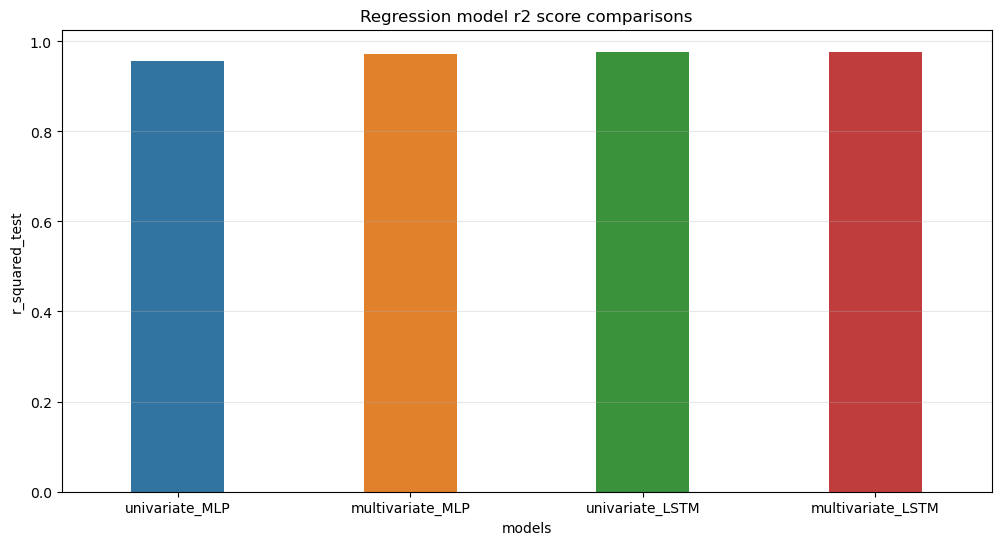

In [254]:
#plotting the accuracies using the r^2 score of each of the models used
plt.figure(figsize=(12,6))
sns.barplot(x='models',y='r_squared_test',data=comparison_metrics,width=.4)
plt.grid(axis='y',alpha=.3)
plt.title('Regression model r2 score comparisons')
plt.show()

### plotting predictions with best model

Best Model: Univariate LSTM

In [370]:
results = pd.DataFrame({'actual values':np.append(y_train,y_test),
                        'predicted values':np.append(y_preds_train_lstm_2,y_preds_test_lstm_2)})

In [372]:
#results.to_csv('best_model_results.csv')

In [373]:
results.head()

,actual values,predicted values
0,6.3,6.094644
1,6.4,6.049635
2,6.2,6.204610
3,6.0,5.904832
4,5.7,5.720385


In [375]:
#getting the length of training data
training_len

36193

In [376]:
train = results['actual values'][:training_len]

In [378]:
valid = results['actual values'][training_len:]

In [379]:
predictions = results['predicted values'][training_len:]

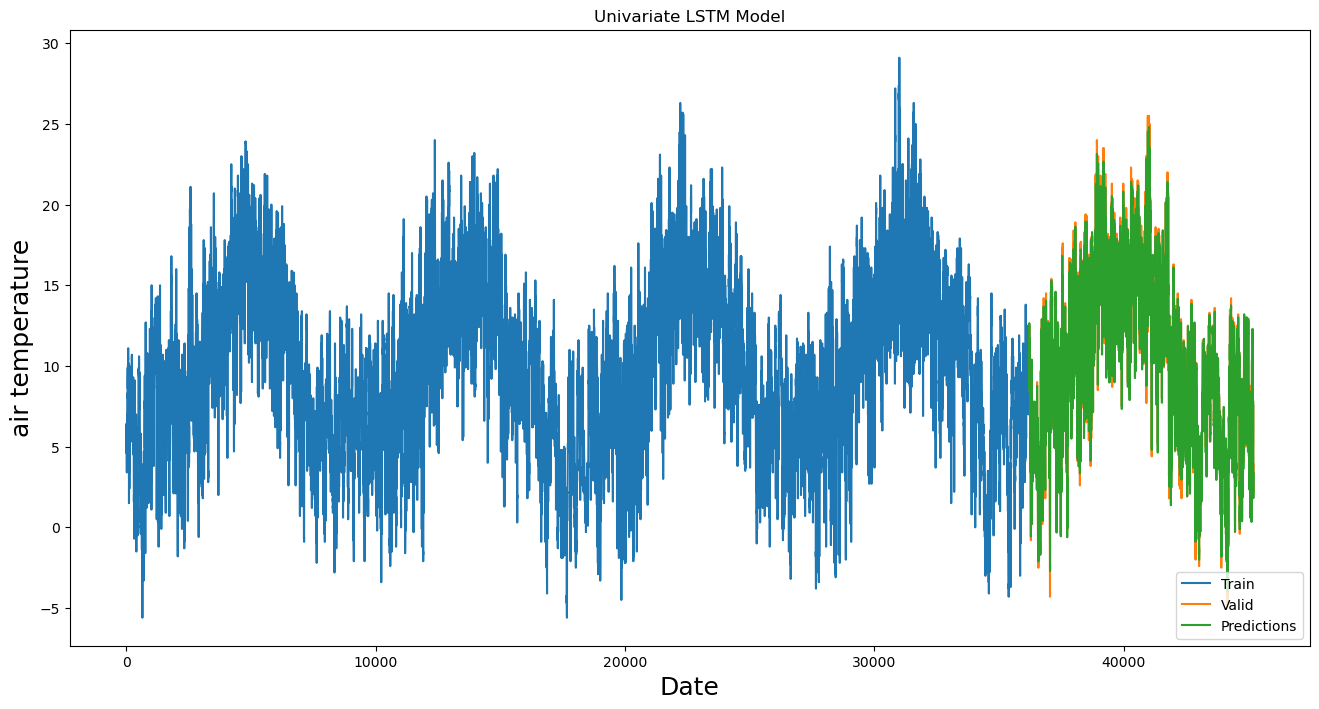

In [381]:
#plotting the predictions
plt.figure(figsize=(16,8))
plt.title('Univariate LSTM Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('air temperature', fontsize=18)
plt.plot(train)
plt.plot(valid)
plt.plot(predictions)

plt.legend(['Train', 'Valid', 'Predictions'], loc = 'lower right')
plt.show()

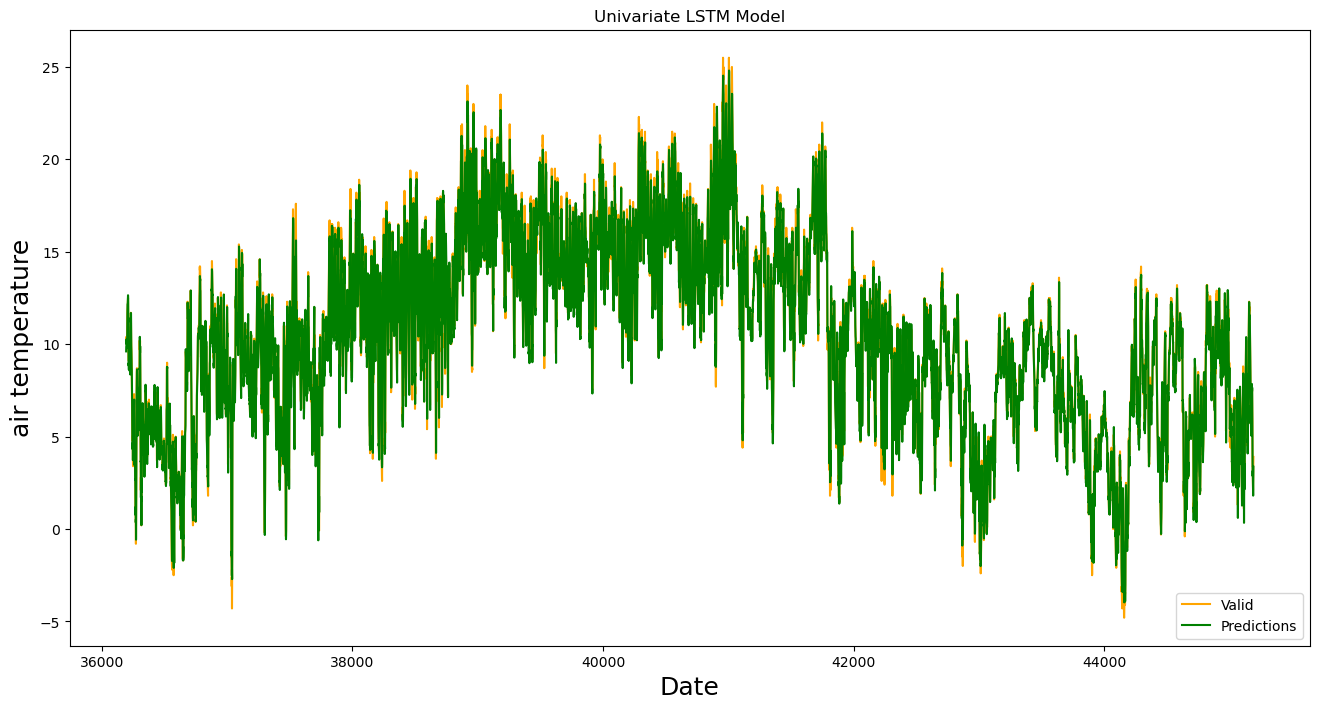

In [385]:
#plotting the predictions
plt.figure(figsize=(16,8))
plt.title('Univariate LSTM Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('air temperature', fontsize=18)
plt.plot(valid,color='orange')
plt.plot(predictions, color='green')

plt.legend([ 'Valid', 'Predictions'], loc = 'lower right')
plt.show()

### predicting a 1 day ahead air temperature using the model

In [392]:
next_day_temp = df.tail(24)['temp'].values
next_day_temp

array([7.5, 7. , 6.5, 6. , 5.7, 5.1, 5.1, 5.2, 5.3, 6.4, 7.2, 7.2, 7.6,
       6.9, 6.7, 5.9, 3.4, 3.4, 3. , 2.5, 2.1, 3.2, 3.5, 3.9])

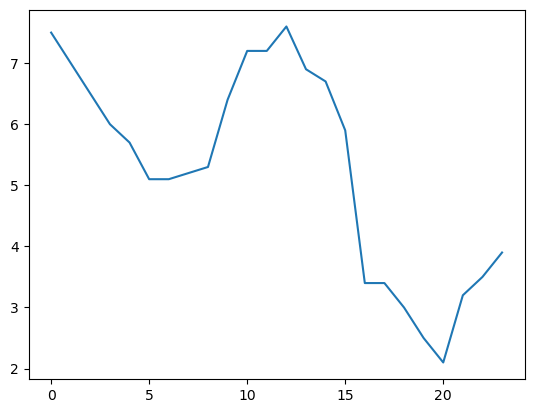

In [393]:
plt.plot(next_day_temp)

In [439]:
##creating an array of temp from 1 day ahead and previous 2 days
all_data=df.tail(72)['temp']
all_data = all_data.reset_index().drop(columns='index')
all_data.head()

,temp
0,3.3
1,4.3
2,5.1
3,5.7
4,6.4


In [440]:
x_test_data = all_data[len(all_data) - len(next_day_temp) - 48:].values

In [441]:
len(x_test_data)

72

In [442]:
x_test_data = np.reshape(x_test_data, (-1, 1))

In [436]:
#x_test_data = scaler.transform(x_test_data)

In [443]:
final_x_test_data = []

for i in range(48, len(x_test_data)):

    final_x_test_data.append(x_test_data[i-48:i, 0])

final_x_test_data = np.array(final_x_test_data)


In [445]:
final_x_test_data = scaler.transform(final_x_test_data)

In [447]:
final_x_test_data = np.reshape(final_x_test_data, (final_x_test_data.shape[0], final_x_test_data.shape[1],1))

In [472]:
predictions = model_lstm_2.predict(final_x_test_data)

1/1 [==============================] - 0s 30ms/step


In [475]:
#pd.DataFrame(predictions).to_csv('predictions_1_day_ahead.csv')

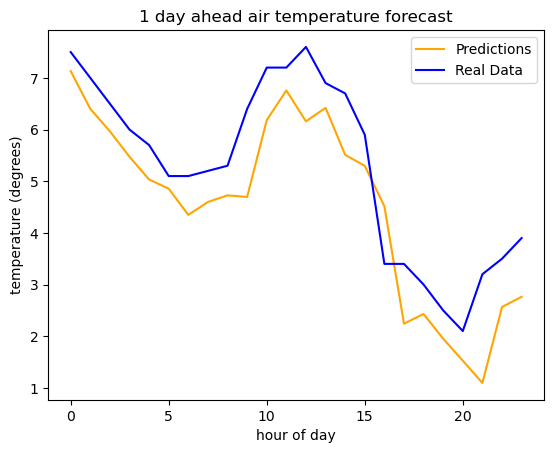

In [481]:
plt.plot(predictions, color = 'orange', label = "Predictions")

plt.plot(next_day_temp, color = 'blue', label = "Real Data")

plt.title('1 day ahead air temperature forecast')
plt.ylabel('temperature (degrees)')
plt.xlabel('hour of day')

plt.legend()